In [1]:
import pydriller
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

**Number of entities for tagged v3.5.3.**

First we change to that version with the command "git checkout tags/v3.5.3".
Then we create a pydriller git object to obtain the number of files we had at that time.

We can also find the defined entities with the following commands:

git checkout tags/v3.5.3

cd app

find . -type f -name "*.rb" | awk -F / '{print $(NF)}' > mastodon_rubyfiles.txt

In [2]:
mastodon_path = "C:\\Users\\luist\\OneDrive\\Escritorio\\SOSY-SE-ASSIGNMENT\\mastodon"
git = pydriller.git.Git(mastodon_path)
files = git.files()
total=[]
for file in files:
    if "C:\\Users\\luist\\OneDrive\\Escritorio\\SOSY-SE-ASSIGNMENT\\mastodon\\app\\" in file and ".rb" in file:
        total.append(file)
entities = []
for f in total:
    entities.append(f.split("\\")[-1])
print("Total number of entities for tag v3.5.3: ", len(entities))

Total number of entities for tag v3.5.3:  815


**Analysis of the modified files**

The time interval chosen was guided by the versions indicated in the different tags. We analyzed the entities defined from the code version tagged as v3.0.0 to version v3.5.3. We assume that version 3.0.0 corresponds to a code version after a major change. Thus, version 3.5.3 has been reached by a series of minor changes and fixes and, consequently, this version and all intermediate versions correspond to a change over a code without major technical and logical differences.

In [3]:
repo = pydriller.Repository(mastodon_path, from_tag="v3.0.0", to_tag="v3.5.3")

In [4]:
# from the commits that belong to the interval between the chosen tags, we extract the information to know the changed entities
# and their complexities
file_changes = {}
file_complexities = {}
for c in repo.traverse_commits():
    for mf in c.modified_files:
        if mf.filename not in file_changes:
            file_changes[mf.filename] = 1
            file_complexities[mf.filename] = [mf.complexity]
        else:
            file_changes[mf.filename] += 1  
            file_complexities[mf.filename].append(mf.complexity)

In [5]:
entity_changes = {}
entity_complexities = {}
for fc in file_changes:
    if fc in entities:
        entity_changes[fc] = file_changes[fc]
        entity_complexities[fc] = file_complexities[fc]

In [6]:
# the dictionary entity_changes contains the entities that have changed in the analyzed interval as keys and the number of
# times that they have changed as values
entity_changes = {k: v for k, v in sorted(entity_changes.items(), key=lambda item: item[1], reverse=True)}

In [7]:
def plot_complexity_trend(entity):
    plt.figure(figsize=(10,7))
    plt.tick_params(axis='both', labelsize=16)
    plt.plot(entity_complexities[entity], marker="o")
    plt.title("Complexity trend - " + entity.replace('_', ' '), fontsize=25)
    plt.xlabel("Commits", fontsize=20)
    plt.ylabel("Complexity", fontsize=20)
    plt.show()

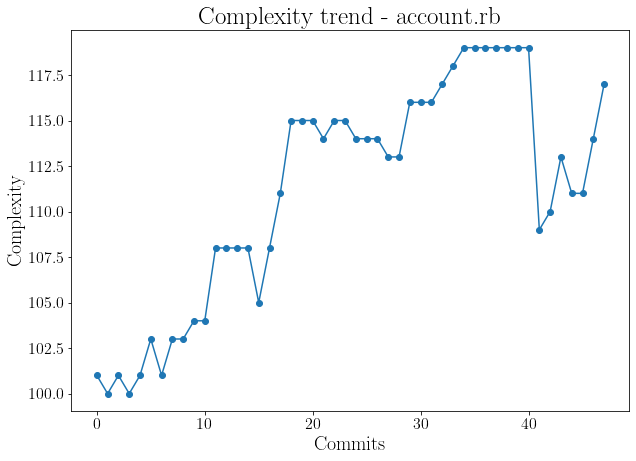

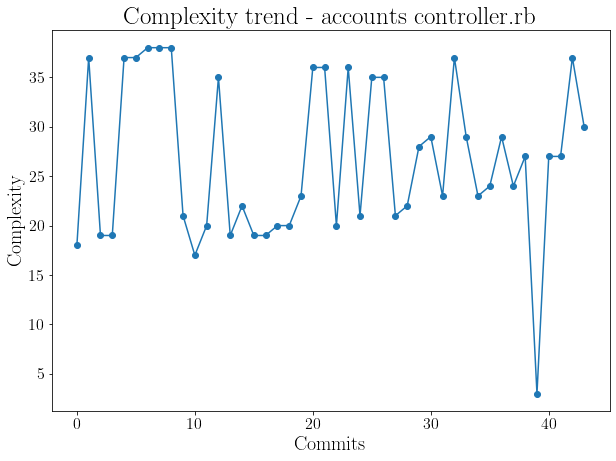

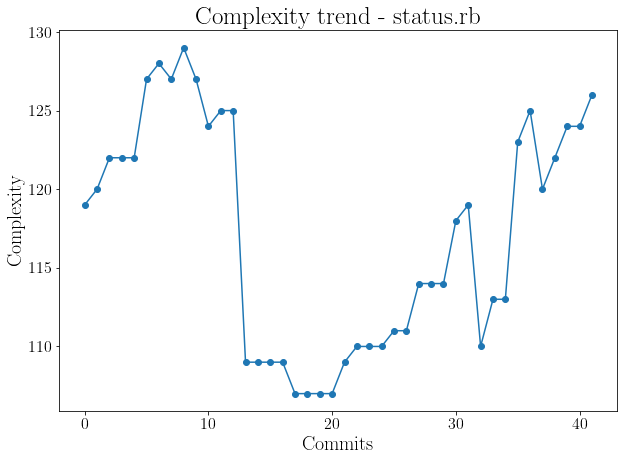

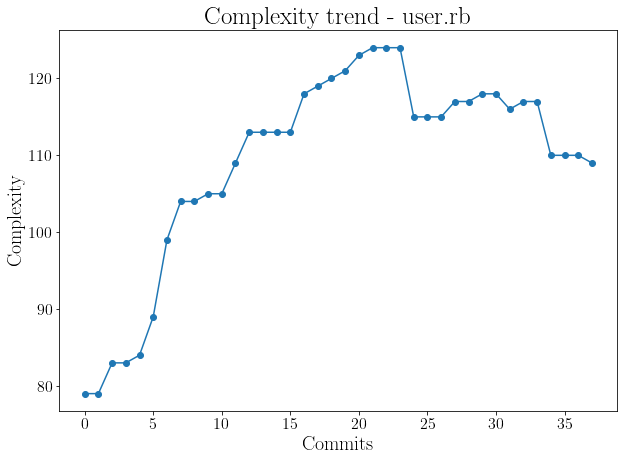

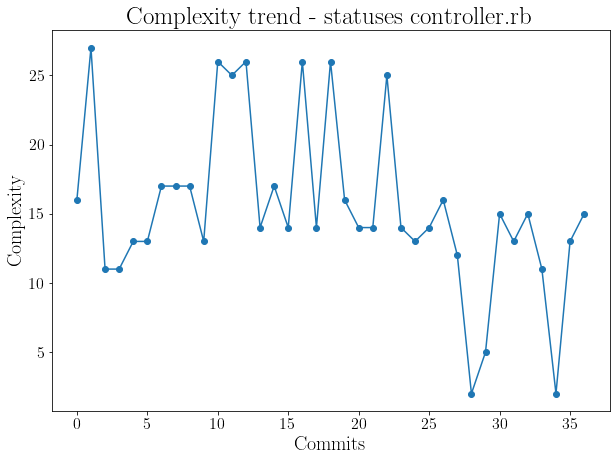

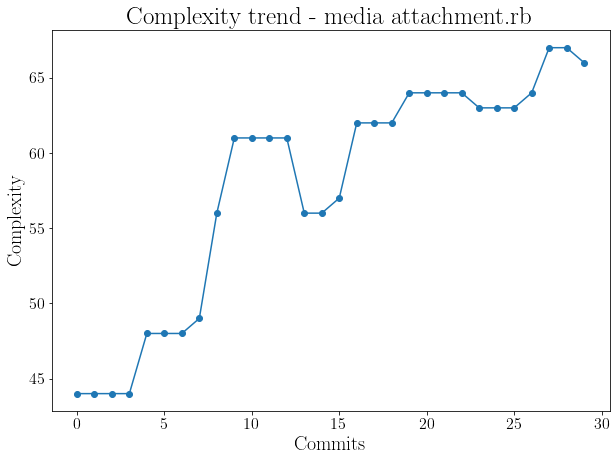

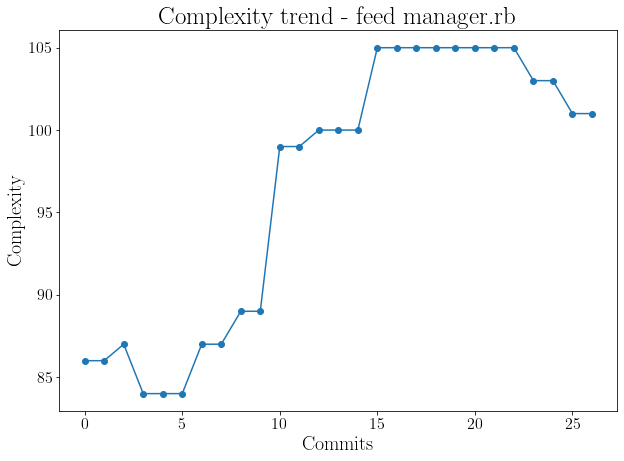

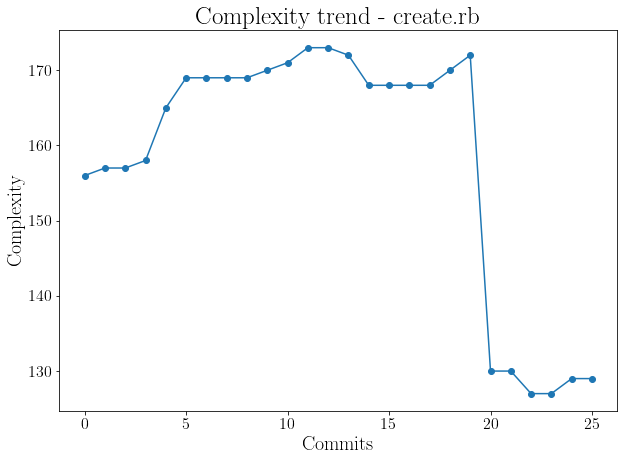

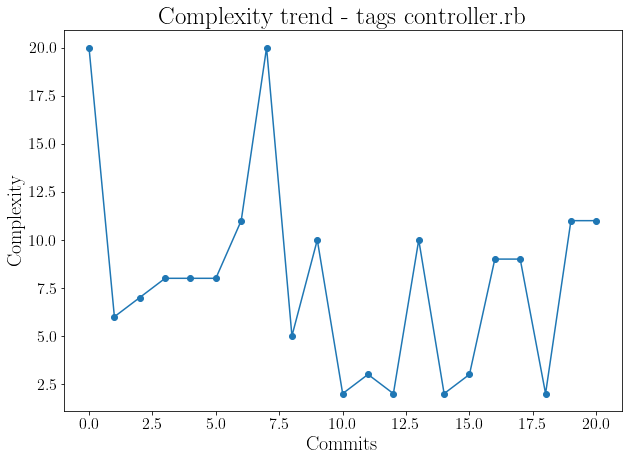

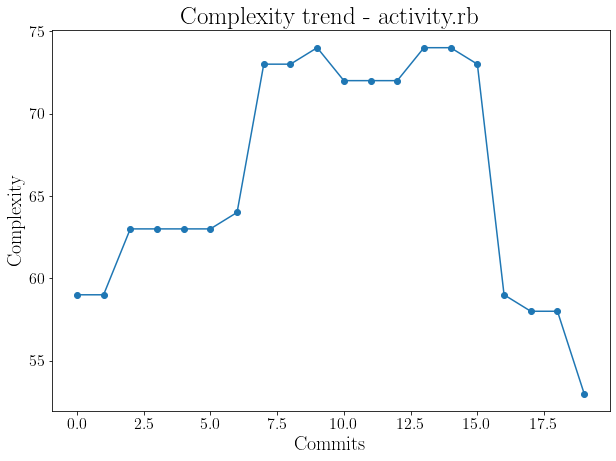

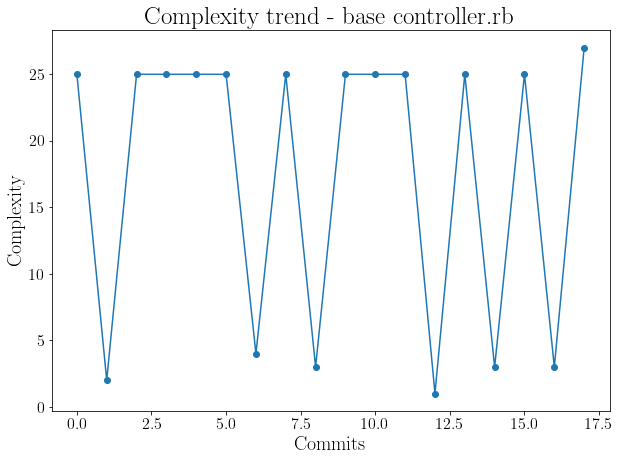

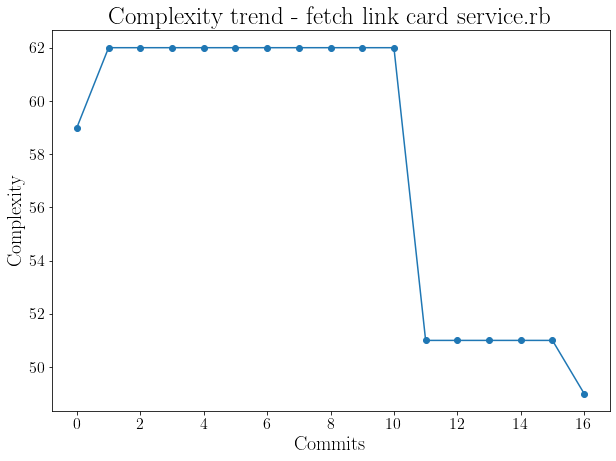

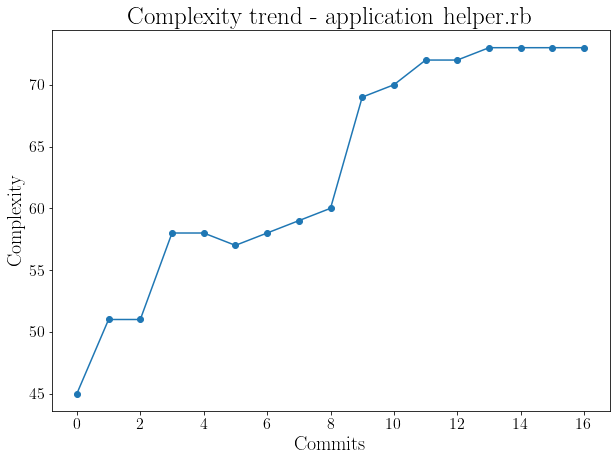

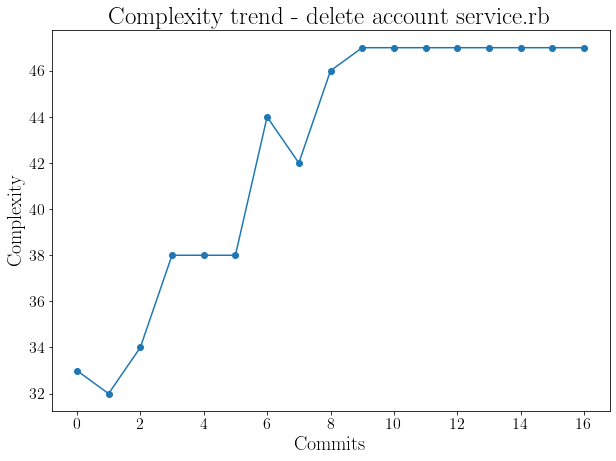

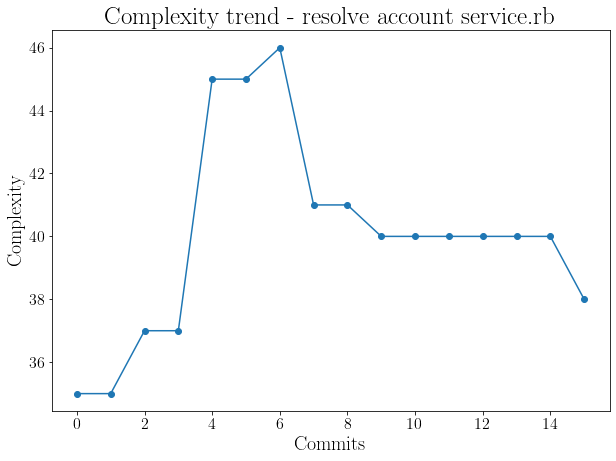

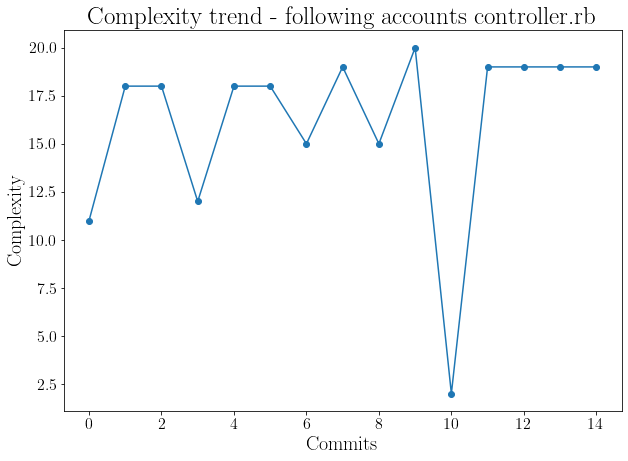

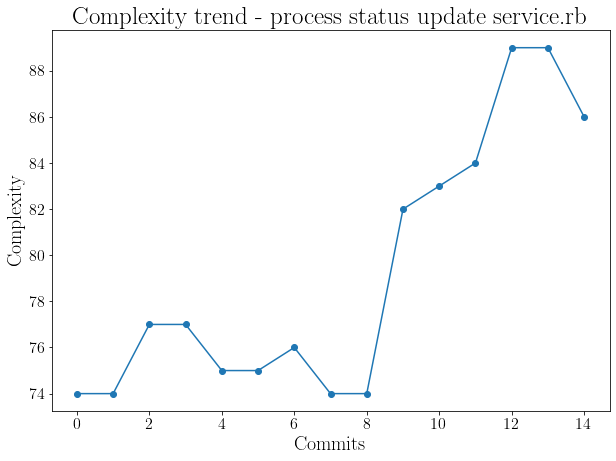

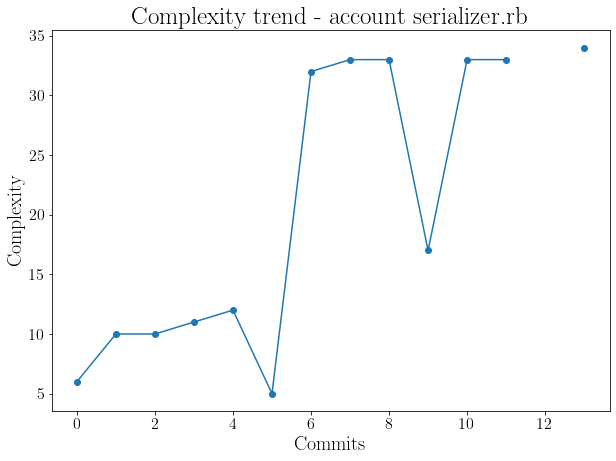

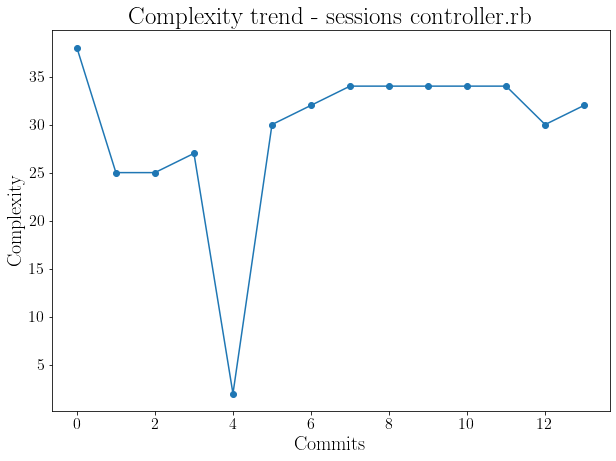

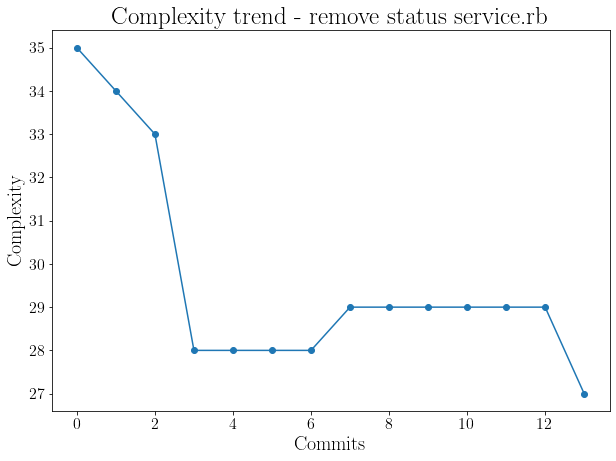

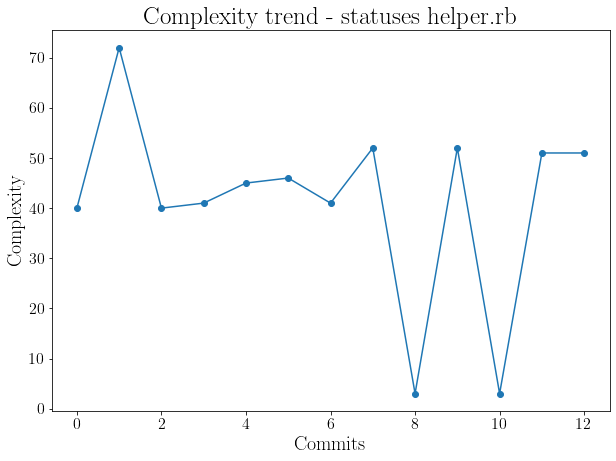

In [8]:
# we study the complexity trend of the entities which are in the top-20 with more modifications. These are our initial
# candidates to be hotspots. The complexity temporal evolution helps us to determine what are our final candidates to
# be hotspots.

number_of_hotspots = 20
for index, ent in enumerate(entity_changes):  
    plot_complexity_trend(ent)
    if index == number_of_hotspots:
        break

**Candidates to hotspots**, based on the number of changes and the complexity trend. Most of them have a complexity trend that increases with time, except create.rb, which, although its complexity decreases for the last commits, it still has a very high complexity value.
- account.rb
- status.rb 
- user.rb 
- feed_manager.rb 
- processs_status_uptate_service.rb
- create.rb 

In [9]:
max_index = 15
most_changed_files = list(entity_changes.keys())[:max_index]

coupling_matrix = np.zeros([max_index,max_index])
for c in repo.traverse_commits():
    for mf in c.modified_files:
        if mf.filename in most_changed_files:
            for mf_inner in c.modified_files:
                if mf_inner.filename in most_changed_files:
                    coupling_matrix[most_changed_files.index(mf.filename)][most_changed_files.index(mf_inner.filename)] += 1

In [10]:
coupling_matrix

array([[48., 10.,  5.,  6.,  5.,  2.,  1.,  3.,  3.,  1.,  4.,  1.,  0.,
         5.,  1.],
       [10., 54.,  2.,  6., 19.,  0.,  0.,  2.,  7.,  1.,  6.,  0.,  2.,
         3.,  1.],
       [ 5.,  2., 42.,  1.,  9.,  2.,  4.,  1.,  4.,  1.,  1.,  1.,  0.,
         5.,  0.],
       [ 6.,  6.,  1., 38.,  3.,  0.,  0.,  1.,  3.,  1.,  4.,  2.,  1.,
         2.,  1.],
       [ 5., 19.,  9.,  3., 51.,  1.,  1.,  2., 14.,  0.,  2.,  0.,  0.,
         3.,  1.],
       [ 2.,  0.,  2.,  0.,  1., 30.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 1.,  0.,  4.,  0.,  1.,  0., 27.,  3.,  0.,  2.,  0.,  2.,  1.,
         2.,  1.],
       [ 3.,  2.,  1.,  1.,  2.,  1.,  3., 26.,  5.,  7.,  2.,  3.,  1.,
         0.,  2.],
       [ 3.,  7.,  4.,  3., 14.,  0.,  0.,  5., 39.,  4.,  1.,  4.,  1.,
         3.,  0.],
       [ 1.,  1.,  1.,  1.,  0.,  0.,  2.,  7.,  4., 20.,  0.,  4.,  0.,
         0.,  3.],
       [ 4.,  6.,  1.,  4.,  2.,  0.,  0.,  2.,  1.,  0., 22.,  1.,  2.,
       

In [19]:
# normalization of the coupling matrix so we can compare different rows
normalized_coupling_matrix = np.zeros([max_index,max_index])
for index, line in enumerate(coupling_matrix):
    normalized_coupling_matrix[index] = line/line[index]

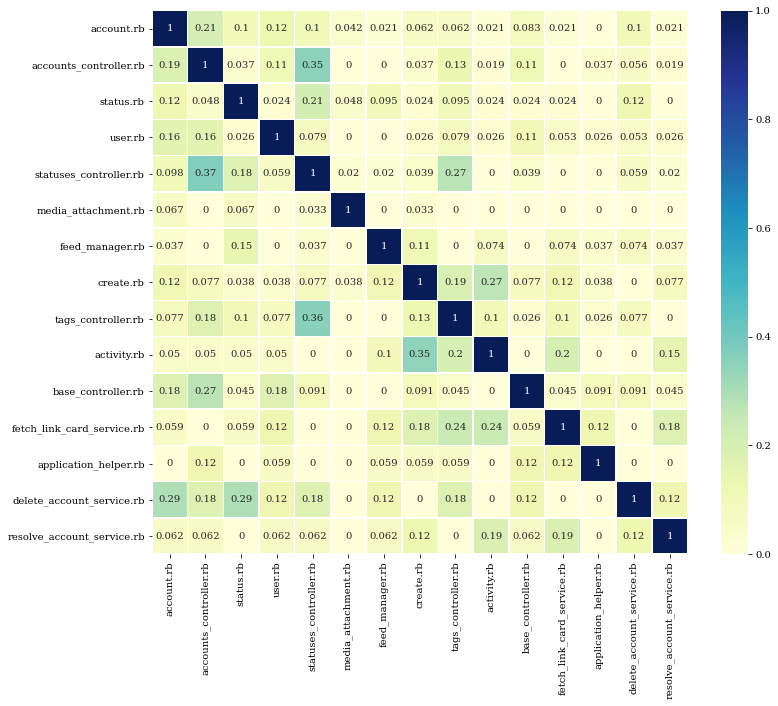

In [25]:
plt.figure(figsize=(12,10))
plt.rc('text', usetex=False)
import seaborn as sns
ax = sns.heatmap(normalized_coupling_matrix, 
                 annot=True, 
                 xticklabels=most_changed_files, 
                 yticklabels=most_changed_files, 
                 cmap="YlGnBu", 
                 linewidth=0.5)